# 1. Bias-Variance Tradeoff

In [2]:
import numpy as np
import pickle
import math
from torch import nn
import torch
from torch.optim import SGD, Adam
import torch.nn
from sklearn.model_selection import KFold
import torch.nn.functional as F
import random
from tqdm import tqdm
import math
import matplotlib.pyplot as plt

from functools import wraps
from time import time
def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

### 1a

In [3]:
# load dataset
(train_X_raw, train_y), (test_X_raw, test_y) = pickle.load(open("./mnist.pkl", "rb"))

# normalize features (not labels)
train_X_norm = train_X_raw / train_X_raw.max()
test_X_norm = test_X_raw / test_X_raw.max()

### 1b

In [1]:
def create_chunks(complete_list, chunk_size=None, num_chunks=None):
    '''
    Cut a list into multiple chunks, each having chunk_size (the last chunk might be less than chunk_size) or having a total of num_chunk chunks
    '''
    chunks = []
    if num_chunks is None:
        num_chunks = math.ceil(len(complete_list) / chunk_size)
    elif chunk_size is None:
        chunk_size = math.ceil(len(complete_list) / num_chunks)
    for i in range(num_chunks):
        chunks.append(complete_list[i * chunk_size: (i + 1) * chunk_size])
    return chunks

# Shuffle the training data
# define permutation index to make sure x values (features) are shuffled with their corresponding labels (y values)
perm_index = np.random.permutation(len(train_X_norm))
# permute to predetermined indices
train_X_perm = train_X_norm[perm_index]
train_y_perm = train_y[perm_index]
# split into 3 chunks
chunks_X = create_chunks(train_X_perm, num_chunks=3)
chunks_y = create_chunks(train_y_perm, num_chunks=3)
# make test data by combining two chunks
test_X1 = np.concatenate(chunks_X[0:2])
test_y1 = np.concatenate(chunks_y[0:2])
# validation data is wan chunk
validate_X1 = chunks_X[2]
validate_y1 = chunks_y[2]


NameError: name 'np' is not defined

In [10]:
class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size, input_transform=lambda x: x.reshape(-1, 1024)):
        """
        A class for training the model
        model: nn.Module
            A pytorch model
        optimizer_type: 'adam' or 'sgd'
        learning_rate: float
        epoch: int
        batch_size: int
        input_transform: func
            Transforms the input data. Can be used to reshape data.
        """
        self.model = model
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
        elif optimizer_type == "Adam":
            self.optimizer = Adam(self.model.parameters(), lr=learning_rate)
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_transform = input_transform

    @timing
    def train(self, inputs, outputs, val_inputs, val_outputs,early_stop=False,l2=False,silent=False):
        """ train self.model with specified arguments
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        val_nputs: np.array, The shape of input_transform(val_input) should be (ndata,nfeatures)
        val_outputs: np.array shape (ndata,)
        early_stop: bool
        l2: bool. Whether or not to use L2 regularization.
        silent: bool. Controls whether or not to print the train and val error during training
        
        @return
        a dictionary of arrays with train and val losses and accuracies
        """
        ### convert data to tensor of correct shape and type here ###
        inputs = torch.tensor(inputs, dtype=torch.float)
        outputs = torch.tensor(outputs, dtype=torch.int64)

        #inputs = inputs.reshape(-1, 1024)
        
        losses = []
        accuracies = []
        val_losses = []
        val_accuracies = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        loss_fn = nn.CrossEntropyLoss()
        
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            # batch indices is number of input entries
            batch_indices = list(range(inputs.shape[0]))
            # shuffle batch indices
            random.shuffle(batch_indices)
            # create chunks
            batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
            epoch_loss = 0
            epoch_acc = 0
            # Batch
            for batch in batch_indices:
                # proportion of the total output that is represented by that batch
                batch_importance = len(batch) / len(outputs)
                batch_input = inputs[batch]
                batch_output = outputs[batch]
                ### make prediction and compute loss with loss function of your choice on this batch ###
                batch_predictions = self.model(batch_input)
                loss = loss_fn(batch_predictions, batch_output)
                if l2:
                    ### Compute the loss with L2 regularization ###
                    self.optimizer = Adam(self.model.parameters(), weight_decay= 1e-5)
                self.optimizer.zero_grad() # sets the gradients of all model parameters to 0
                loss.backward() # backpropagates
                self.optimizer.step() # updates parameters based on gradients calculated in backprop
                ### Compute epoch_loss and epoch_acc
                # number of accurately predicted points / num points in batch * importance
                acc = torch.argmax(batch_predictions, dim=1).eq(batch_output).sum().item() / len(batch_output) * batch_importance
                epoch_loss += loss.item() * batch_importance
                epoch_acc += acc
            val_loss, val_acc = self.evaluate(val_inputs, val_outputs, print_acc=False)
            if n_epoch % 10 ==0 and not silent: 
                print("Epoch %d/%d - Loss: %.3f - Acc: %.3f" % (n_epoch + 1, self.epoch, epoch_loss, epoch_acc))
                print("              Val_loss: %.3f - Val_acc: %.3f" % (val_loss, val_acc))
            losses.append(epoch_loss)
            accuracies.append(epoch_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    # saves current state of model's parameters to dict weights
                    weights = self.model.state_dict()

        if early_stop:
            # loads saved parameters back into model
            self.model.load_state_dict(weights)    
        
        # plot training and validation losses
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        plt.plot(losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title('Training vs Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # plot training and validation accuracy
        plt.subplot(1,2,2)
        plt.plot(accuracies, label='Training Accuracy')
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.title('Training vs Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()

        return {"losses": losses, "accuracies": accuracies, "val_losses": val_losses, "val_accuracies": val_accuracies}
        
    def evaluate(self, inputs, outputs, print_acc=True):
        """ 
        Evaluate model on provided input and output
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        print_acc: bool
        
        @return
        losses: float
        acc: float
        """
        inputs = torch.tensor(inputs, dtype= torch.float)
        outputs = torch.tensor(outputs, dtype=torch.int64)
        #inputs = inputs.reshape(-1, 1024)
        loss_fn = nn.CrossEntropyLoss()

        self.model.eval()
        batch_indices = list(range(inputs.shape[0]))
        batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
        acc = 0
        loss = 0

        for batch in batch_indices:
            batch_importance = len(batch) / len(outputs)
            batch_input = inputs[batch]
            batch_output = outputs[batch]
            batch_predictions = self.model(batch_input)
            with torch.no_grad():
                # compute prediction and loss
                batch_acc = torch.argmax(batch_predictions, dim=1).eq(batch_output).sum().item() / len(batch_output) * batch_importance
                # how much 
                loss += loss_fn(batch_predictions, batch_output) * batch_importance
                acc = acc + batch_acc

        if print_acc:
            print("Accuracy: %.3f" % acc)
        return loss, acc

In [6]:
class ANN(torch.nn.Module):
    """
    This class defines an ANN.
    """
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0):
        super().__init__()
        self.hidden_layer = torch.nn.Linear(input_size, hidden_size)
        self.output_layer = torch.nn.Linear(hidden_size, output_size)
        self.activation = torch.nn.Sigmoid()
        self.dropout = nn.Dropout(p = dropout_rate)

    def forward(self, x0):
        x1 = self.hidden_layer(x0)
        x2 = self.activation(x1)
        x2 = self.dropout(x2)
        x3 = self.output_layer(x2)
        x4 = self.activation(x3)

        return x4

### 1c
Devise an ANN that has 2 computing layers: a hidden layer of size 3
neurons and the final output layer of 10 output neurons and use a sigmoid
activation function. Use the ADAM optimizer with learning rate of 2e-3,
batchsize of 128, and 50 epochs.

  4%|█▊                                          | 2/50 [00:00<00:10,  4.62it/s]

Epoch 1/50 - Loss: 2.209 - Acc: 0.290
              Val_loss: 2.135 - Val_acc: 0.469


 22%|█████████▍                                 | 11/50 [00:02<00:06,  5.61it/s]

Epoch 11/50 - Loss: 1.779 - Acc: 0.548
              Val_loss: 1.779 - Val_acc: 0.551


 44%|██████████████████▉                        | 22/50 [00:04<00:05,  5.27it/s]

Epoch 21/50 - Loss: 1.717 - Acc: 0.562
              Val_loss: 1.722 - Val_acc: 0.555


 64%|███████████████████████████▌               | 32/50 [00:05<00:03,  5.72it/s]

Epoch 31/50 - Loss: 1.684 - Acc: 0.628
              Val_loss: 1.693 - Val_acc: 0.627


 84%|████████████████████████████████████       | 42/50 [00:07<00:01,  5.71it/s]

Epoch 41/50 - Loss: 1.669 - Acc: 0.624
              Val_loss: 1.679 - Val_acc: 0.610


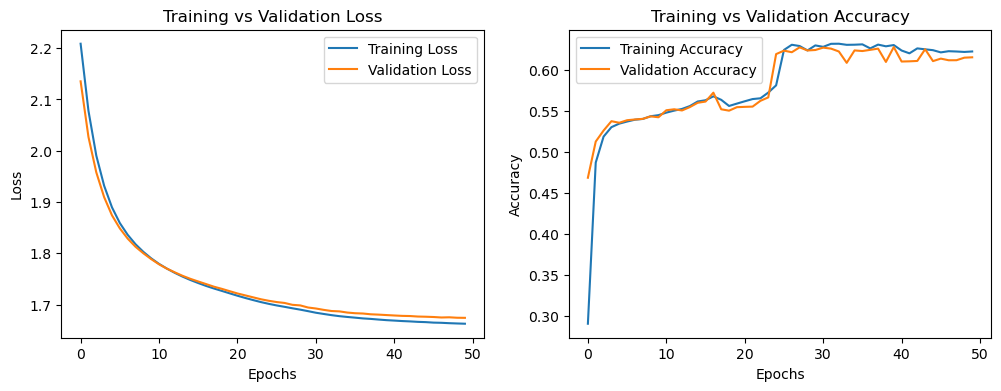

func:'train'  took: 9.2838 sec


  4%|█▊                                          | 2/50 [00:00<00:08,  5.74it/s]

Epoch 1/50 - Loss: 2.190 - Acc: 0.333
              Val_loss: 2.117 - Val_acc: 0.375


 24%|██████████▎                                | 12/50 [00:02<00:06,  5.68it/s]

Epoch 11/50 - Loss: 1.792 - Acc: 0.542
              Val_loss: 1.793 - Val_acc: 0.539


 44%|██████████████████▉                        | 22/50 [00:04<00:05,  5.10it/s]

Epoch 21/50 - Loss: 1.724 - Acc: 0.537
              Val_loss: 1.733 - Val_acc: 0.522


 62%|██████████████████████████▋                | 31/50 [00:05<00:03,  5.00it/s]

Epoch 31/50 - Loss: 1.702 - Acc: 0.545
              Val_loss: 1.714 - Val_acc: 0.532


 84%|████████████████████████████████████       | 42/50 [00:07<00:01,  5.36it/s]

Epoch 41/50 - Loss: 1.692 - Acc: 0.546
              Val_loss: 1.707 - Val_acc: 0.531


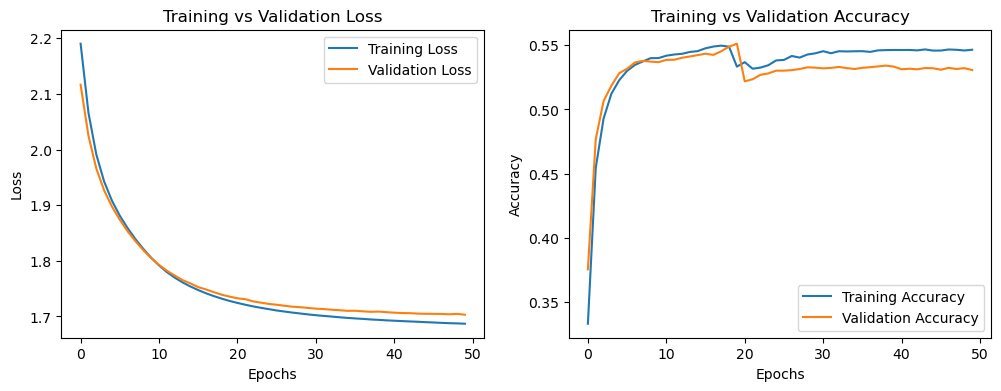

func:'train'  took: 9.4869 sec


  4%|█▊                                          | 2/50 [00:00<00:08,  5.38it/s]

Epoch 1/50 - Loss: 2.197 - Acc: 0.326
              Val_loss: 2.124 - Val_acc: 0.499


 24%|██████████▎                                | 12/50 [00:02<00:06,  5.43it/s]

Epoch 11/50 - Loss: 1.794 - Acc: 0.589
              Val_loss: 1.791 - Val_acc: 0.573


 44%|██████████████████▉                        | 22/50 [00:04<00:05,  5.33it/s]

Epoch 21/50 - Loss: 1.722 - Acc: 0.596
              Val_loss: 1.725 - Val_acc: 0.582


 64%|███████████████████████████▌               | 32/50 [00:05<00:03,  5.48it/s]

Epoch 31/50 - Loss: 1.696 - Acc: 0.578
              Val_loss: 1.704 - Val_acc: 0.531


 84%|████████████████████████████████████       | 42/50 [00:07<00:01,  5.55it/s]

Epoch 41/50 - Loss: 1.685 - Acc: 0.549
              Val_loss: 1.695 - Val_acc: 0.566


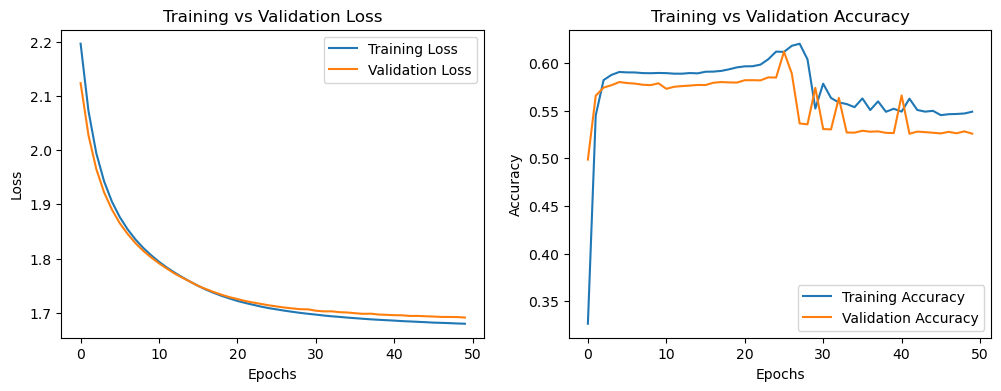

func:'train'  took: 9.3534 sec


In [6]:
kf = KFold(3, shuffle=True, random_state=49)

for idx, (train_index, val_index) in enumerate(kf.split(train_X_norm)):
    X_train_fold, X_val_fold = train_X_norm[train_index], train_X_norm[val_index]
    y_train_fold, y_val_fold = train_y[train_index], train_y[val_index]

    model1 = ANN(1024, 3, 10)
    train_model1 = Trainer(model1, "Adam", 2e-3, 50, 128)
    model1_results = train_model1.train(X_train_fold, y_train_fold, X_val_fold, y_val_fold, l2=False)

### 1d
Devise another ANN with hidden layer of size 50. Do the same as in (1c). Plot your training and
validation curve, and comment on the bias-variance tradeoff with this choice.

  2%|▉                                           | 1/50 [00:00<00:13,  3.68it/s]

Epoch 1/50 - Loss: 1.828 - Acc: 0.804
              Val_loss: 1.649 - Val_acc: 0.890


 22%|█████████▍                                 | 11/50 [00:02<00:09,  3.97it/s]

Epoch 11/50 - Loss: 1.511 - Acc: 0.953
              Val_loss: 1.520 - Val_acc: 0.940


 42%|██████████████████                         | 21/50 [00:05<00:07,  4.08it/s]

Epoch 21/50 - Loss: 1.493 - Acc: 0.967
              Val_loss: 1.511 - Val_acc: 0.947


 62%|██████████████████████████▋                | 31/50 [00:07<00:04,  4.10it/s]

Epoch 31/50 - Loss: 1.485 - Acc: 0.975
              Val_loss: 1.509 - Val_acc: 0.951


 82%|███████████████████████████████████▎       | 41/50 [00:10<00:02,  4.04it/s]

Epoch 41/50 - Loss: 1.480 - Acc: 0.979
              Val_loss: 1.509 - Val_acc: 0.952


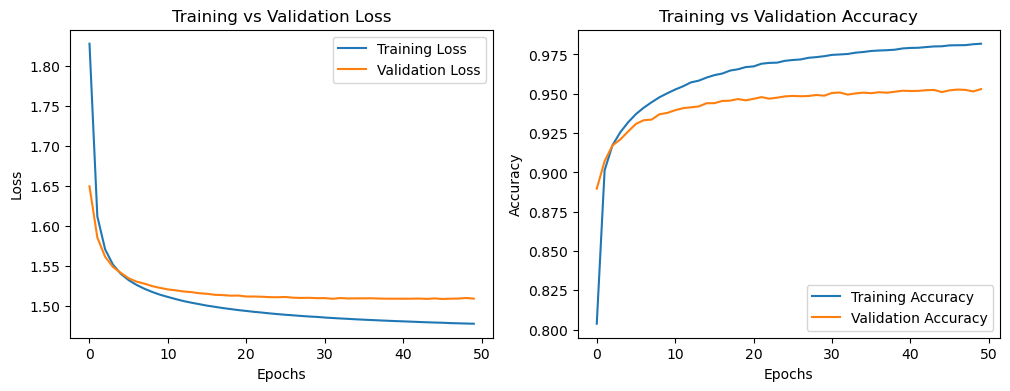

func:'train'  took: 12.7032 sec


  2%|▉                                           | 1/50 [00:00<00:14,  3.47it/s]

Epoch 1/50 - Loss: 1.828 - Acc: 0.799
              Val_loss: 1.654 - Val_acc: 0.882


 22%|█████████▍                                 | 11/50 [00:02<00:10,  3.89it/s]

Epoch 11/50 - Loss: 1.509 - Acc: 0.954
              Val_loss: 1.521 - Val_acc: 0.942


 42%|██████████████████                         | 21/50 [00:05<00:07,  4.02it/s]

Epoch 21/50 - Loss: 1.491 - Acc: 0.970
              Val_loss: 1.510 - Val_acc: 0.951


 62%|██████████████████████████▋                | 31/50 [00:07<00:04,  4.06it/s]

Epoch 31/50 - Loss: 1.483 - Acc: 0.977
              Val_loss: 1.507 - Val_acc: 0.955


 82%|███████████████████████████████████▎       | 41/50 [00:10<00:02,  4.05it/s]

Epoch 41/50 - Loss: 1.478 - Acc: 0.981
              Val_loss: 1.506 - Val_acc: 0.955


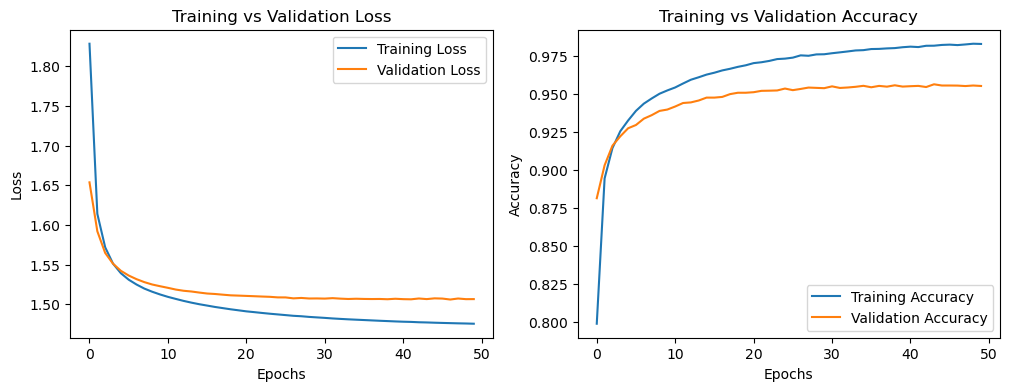

func:'train'  took: 12.6804 sec


  2%|▉                                           | 1/50 [00:00<00:13,  3.70it/s]

Epoch 1/50 - Loss: 1.827 - Acc: 0.795
              Val_loss: 1.648 - Val_acc: 0.892


 22%|█████████▍                                 | 11/50 [00:02<00:10,  3.78it/s]

Epoch 11/50 - Loss: 1.511 - Acc: 0.953
              Val_loss: 1.518 - Val_acc: 0.945


 42%|██████████████████                         | 21/50 [00:05<00:08,  3.62it/s]

Epoch 21/50 - Loss: 1.493 - Acc: 0.968
              Val_loss: 1.507 - Val_acc: 0.955


 62%|██████████████████████████▋                | 31/50 [00:08<00:04,  3.94it/s]

Epoch 31/50 - Loss: 1.484 - Acc: 0.975
              Val_loss: 1.503 - Val_acc: 0.957


 82%|███████████████████████████████████▎       | 41/50 [00:10<00:02,  4.08it/s]

Epoch 41/50 - Loss: 1.480 - Acc: 0.979
              Val_loss: 1.503 - Val_acc: 0.959


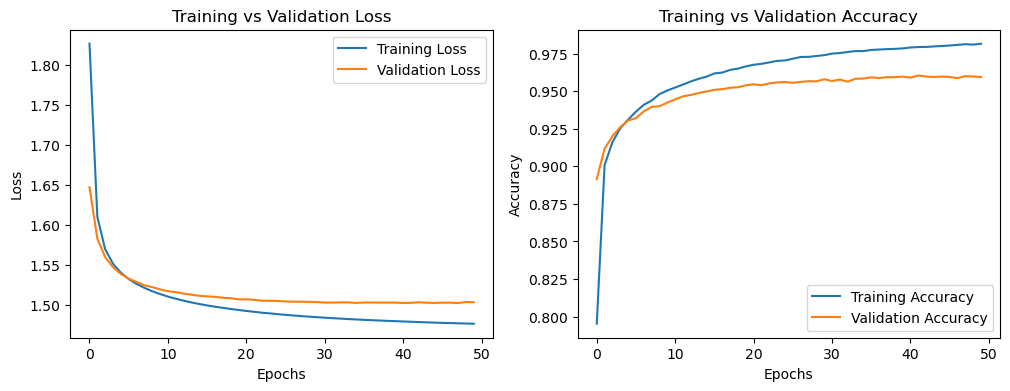

func:'train'  took: 13.0566 sec


In [7]:
kf = KFold(3, shuffle=True, random_state=49)

for idx, (train_index, val_index) in enumerate(kf.split(train_X_norm)):
    X_train_fold, X_val_fold = train_X_norm[train_index], train_X_norm[val_index]
    y_train_fold, y_val_fold = train_y[train_index], train_y[val_index]

    model2 = ANN(1024, 50, 10)
    train_model2 = Trainer(model2, "Adam", 2e-3, 50, 128)
    model2_results = train_model2.train(X_train_fold, y_train_fold, X_val_fold, y_val_fold, l2=False)

With 50 hidden neurons, accuracy is significantly higher (~0.95 in the validation set of model2 as opposed to ~0.60 in the validation set of model1). However, the validation loss is higher than the training loss for model2, which suggests some overfitting to the training data. In this case, I think the higher variance is hurting a bit. Maybe there's a sweet spot between 3 neurons and 50 neurons where we have a lower variance and higher bias that avoids underfitting.

# 2. Deep Learning and Regularization

### 2a
Using the ANN from 1(d), utilize dropout with 15%. Compare your training and test accuracy to results
in (d).

  2%|▉                                           | 1/50 [00:00<00:13,  3.60it/s]

Epoch 1/50 - Loss: 1.841 - Acc: 0.770
              Val_loss: 1.655 - Val_acc: 0.884


 22%|█████████▍                                 | 11/50 [00:02<00:10,  3.76it/s]

Epoch 11/50 - Loss: 1.524 - Acc: 0.941
              Val_loss: 1.522 - Val_acc: 0.939


 42%|██████████████████                         | 21/50 [00:05<00:07,  3.90it/s]

Epoch 21/50 - Loss: 1.507 - Acc: 0.955
              Val_loss: 1.511 - Val_acc: 0.948


 62%|██████████████████████████▋                | 31/50 [00:08<00:04,  3.96it/s]

Epoch 31/50 - Loss: 1.500 - Acc: 0.961
              Val_loss: 1.508 - Val_acc: 0.952


 82%|███████████████████████████████████▎       | 41/50 [00:10<00:02,  3.94it/s]

Epoch 41/50 - Loss: 1.495 - Acc: 0.966
              Val_loss: 1.506 - Val_acc: 0.954


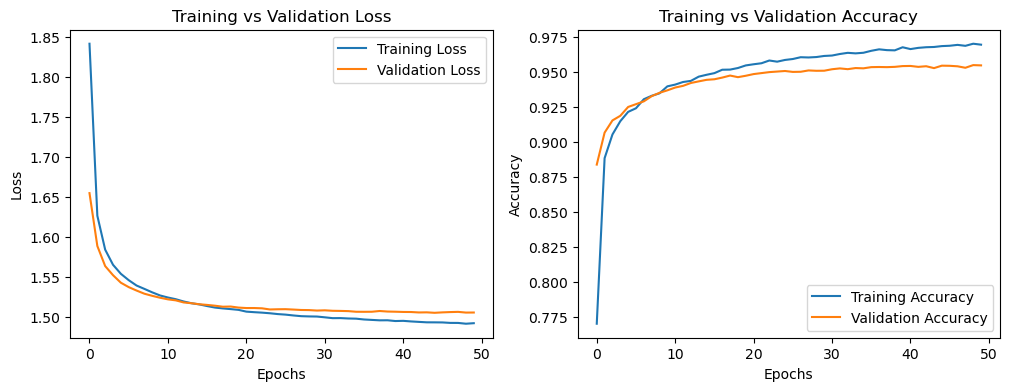

func:'train'  took: 12.9944 sec


  2%|▉                                           | 1/50 [00:00<00:12,  3.78it/s]

Epoch 1/50 - Loss: 1.843 - Acc: 0.771
              Val_loss: 1.660 - Val_acc: 0.879


 22%|█████████▍                                 | 11/50 [00:02<00:09,  3.91it/s]

Epoch 11/50 - Loss: 1.523 - Acc: 0.941
              Val_loss: 1.523 - Val_acc: 0.936


 42%|██████████████████                         | 21/50 [00:05<00:07,  3.75it/s]

Epoch 21/50 - Loss: 1.506 - Acc: 0.955
              Val_loss: 1.512 - Val_acc: 0.946


 62%|██████████████████████████▋                | 31/50 [00:08<00:05,  3.74it/s]

Epoch 31/50 - Loss: 1.498 - Acc: 0.963
              Val_loss: 1.508 - Val_acc: 0.952


 82%|███████████████████████████████████▎       | 41/50 [00:10<00:02,  3.90it/s]

Epoch 41/50 - Loss: 1.493 - Acc: 0.968
              Val_loss: 1.505 - Val_acc: 0.954


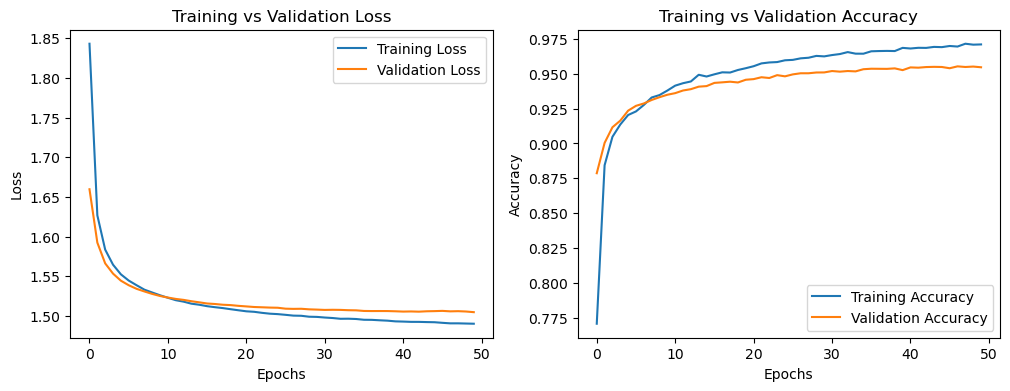

func:'train'  took: 13.1199 sec


  2%|▉                                           | 1/50 [00:00<00:13,  3.60it/s]

Epoch 1/50 - Loss: 1.837 - Acc: 0.779
              Val_loss: 1.653 - Val_acc: 0.888


 22%|█████████▍                                 | 11/50 [00:02<00:10,  3.85it/s]

Epoch 11/50 - Loss: 1.524 - Acc: 0.941
              Val_loss: 1.519 - Val_acc: 0.942


 42%|██████████████████                         | 21/50 [00:05<00:07,  3.85it/s]

Epoch 21/50 - Loss: 1.508 - Acc: 0.954
              Val_loss: 1.509 - Val_acc: 0.950


 62%|██████████████████████████▋                | 31/50 [00:08<00:05,  3.74it/s]

Epoch 31/50 - Loss: 1.500 - Acc: 0.961
              Val_loss: 1.505 - Val_acc: 0.954


 82%|███████████████████████████████████▎       | 41/50 [00:10<00:02,  3.80it/s]

Epoch 41/50 - Loss: 1.496 - Acc: 0.965
              Val_loss: 1.503 - Val_acc: 0.956


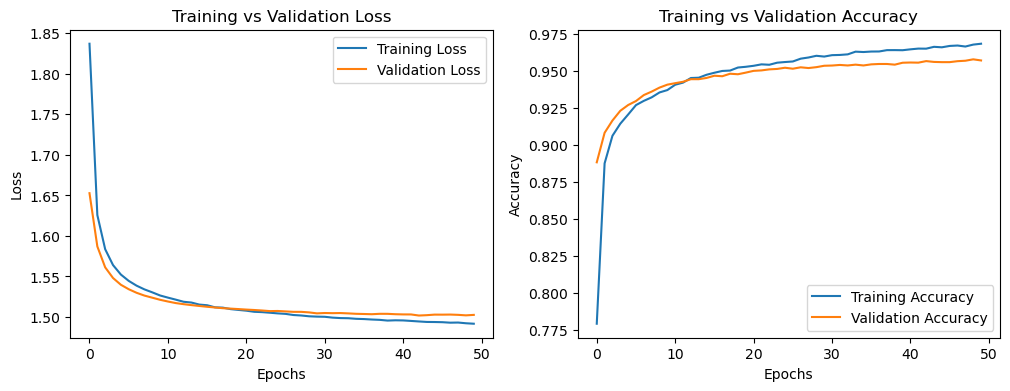

func:'train'  took: 13.2643 sec


In [8]:
kf = KFold(3, shuffle=True, random_state=49)

for idx, (train_index, val_index) in enumerate(kf.split(train_X_norm)):
    X_train_fold, X_val_fold = train_X_norm[train_index], train_X_norm[val_index]
    y_train_fold, y_val_fold = train_y[train_index], train_y[val_index]

    model3 = ANN(1024, 50, 10, dropout_rate=0.15)
    train_model3 = Trainer(model3, "Adam", 2e-3, 50, 128)
    model3_results = train_model3.train(X_train_fold, y_train_fold, X_val_fold, y_val_fold, l2=False)

With a 15% dropout, the training and validation losses are much closer to one another (though there is still overfitting). This is expected, as dropout is supposed to reduce overfitting. The accuracies for both are about the same.

### 2b
Using the ANN from 1(d), utilize L2 regularization with lambda=1e-5. How does the result compare to
(d)?

  2%|▉                                           | 1/50 [00:00<00:15,  3.24it/s]

Epoch 1/50 - Loss: 1.943 - Acc: 0.758
              Val_loss: 1.738 - Val_acc: 0.855


 22%|█████████▍                                 | 11/50 [00:03<00:11,  3.43it/s]

Epoch 11/50 - Loss: 1.536 - Acc: 0.930
              Val_loss: 1.539 - Val_acc: 0.925


 42%|██████████████████                         | 21/50 [00:06<00:08,  3.52it/s]

Epoch 21/50 - Loss: 1.522 - Acc: 0.941
              Val_loss: 1.529 - Val_acc: 0.934


 62%|██████████████████████████▋                | 31/50 [00:08<00:05,  3.59it/s]

Epoch 31/50 - Loss: 1.515 - Acc: 0.948
              Val_loss: 1.524 - Val_acc: 0.938


 82%|███████████████████████████████████▎       | 41/50 [00:11<00:02,  3.58it/s]

Epoch 41/50 - Loss: 1.511 - Acc: 0.951
              Val_loss: 1.521 - Val_acc: 0.941


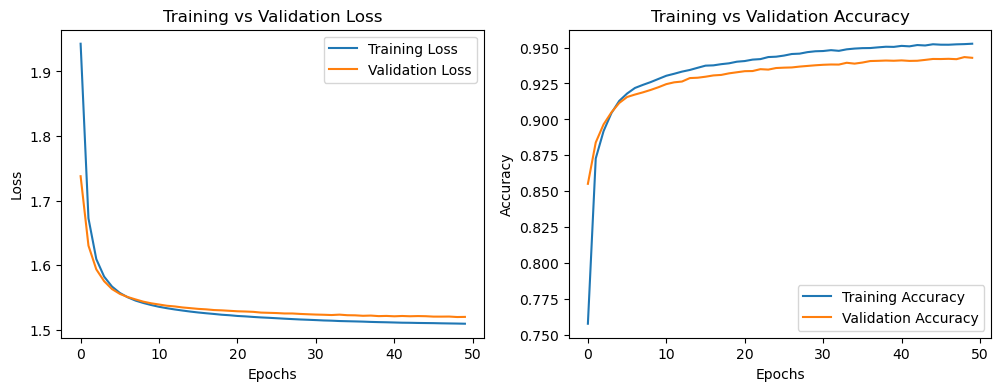

func:'train'  took: 14.3644 sec


  2%|▉                                           | 1/50 [00:00<00:14,  3.47it/s]

Epoch 1/50 - Loss: 1.946 - Acc: 0.751
              Val_loss: 1.739 - Val_acc: 0.861


 22%|█████████▍                                 | 11/50 [00:03<00:10,  3.61it/s]

Epoch 11/50 - Loss: 1.536 - Acc: 0.928
              Val_loss: 1.541 - Val_acc: 0.924


 42%|██████████████████                         | 21/50 [00:05<00:08,  3.57it/s]

Epoch 21/50 - Loss: 1.522 - Acc: 0.940
              Val_loss: 1.531 - Val_acc: 0.933


 62%|██████████████████████████▋                | 31/50 [00:08<00:05,  3.65it/s]

Epoch 31/50 - Loss: 1.515 - Acc: 0.947
              Val_loss: 1.526 - Val_acc: 0.938


 82%|███████████████████████████████████▎       | 41/50 [00:11<00:02,  3.64it/s]

Epoch 41/50 - Loss: 1.512 - Acc: 0.951
              Val_loss: 1.523 - Val_acc: 0.941


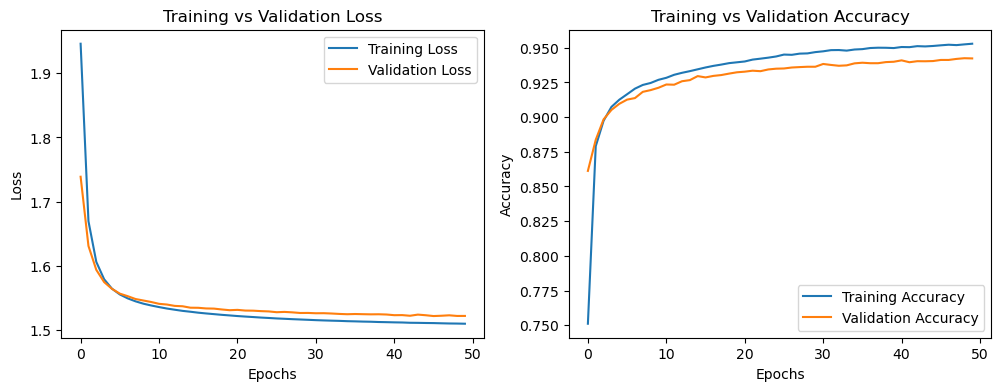

func:'train'  took: 13.9580 sec


  2%|▉                                           | 1/50 [00:00<00:14,  3.32it/s]

Epoch 1/50 - Loss: 1.947 - Acc: 0.721
              Val_loss: 1.735 - Val_acc: 0.855


 22%|█████████▍                                 | 11/50 [00:03<00:10,  3.64it/s]

Epoch 11/50 - Loss: 1.537 - Acc: 0.928
              Val_loss: 1.538 - Val_acc: 0.926


 42%|██████████████████                         | 21/50 [00:05<00:07,  3.66it/s]

Epoch 21/50 - Loss: 1.523 - Acc: 0.939
              Val_loss: 1.527 - Val_acc: 0.935


 62%|██████████████████████████▋                | 31/50 [00:08<00:05,  3.67it/s]

Epoch 31/50 - Loss: 1.516 - Acc: 0.946
              Val_loss: 1.522 - Val_acc: 0.941


 82%|███████████████████████████████████▎       | 41/50 [00:11<00:02,  3.64it/s]

Epoch 41/50 - Loss: 1.513 - Acc: 0.950
              Val_loss: 1.520 - Val_acc: 0.944


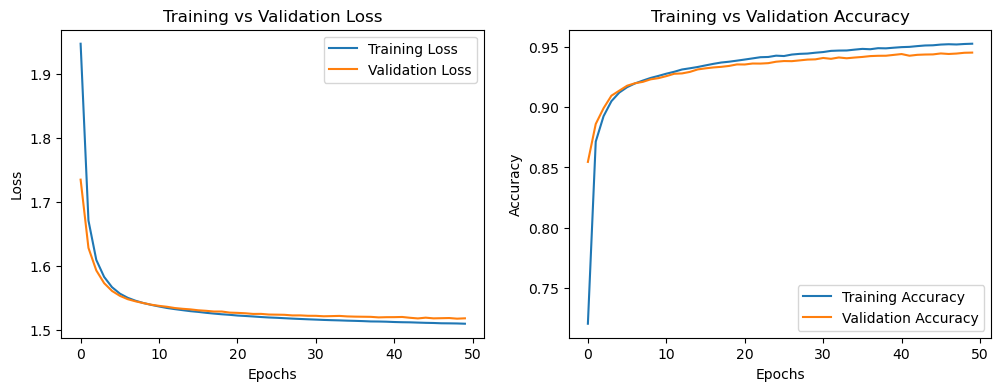

func:'train'  took: 13.8213 sec


In [9]:
kf = KFold(3, shuffle=True, random_state=49)

for idx, (train_index, val_index) in enumerate(kf.split(train_X_norm)):
    X_train_fold, X_val_fold = train_X_norm[train_index], train_X_norm[val_index]
    y_train_fold, y_val_fold = train_y[train_index], train_y[val_index]

    model4 = ANN(1024, 50, 10)
    train_model4 = Trainer(model4, "Adam", 2e-3, 50, 128)
    model4_results = train_model4.train(X_train_fold, y_train_fold, X_val_fold, y_val_fold, l2=True)

Using L2 loss, the training loss is lower than the validation loss. This is good, because L2 loss is also meant to help reduce overfitting by making weights more evenly distributed. However, the model accuracy is a bit lower than that of the model in 1d (~0.93 in 2b model vs ~0.95 in 1d model).

Of the three models in 1d, 2a and 2b, 2b's model has the least difference between training and validation loss without overfitting.

### 2c
Use principal component analysis on the input, to create a reduced set of input features, keeping 99% of
the variance. This is a type of data transformation! How many parameters do you have in this case and how
does it compare to the original model (i.e. the ANN in 1(d))?

In [8]:
from sklearn.decomposition import PCA

# keep 99% of the variance
pca = PCA(n_components=0.99)
# reshape test_X data
train_X_flat = train_X_norm.reshape(-1, 1024)
# PCA fit and transform flattened X
X_pca =pca.fit_transform(train_X_flat)

The reduced model for PCA has 331 parameters, which is much fewer than the original model which had 1024 (32*32).

### 2d
Use the regularization settings (2a or 2b) that give the best result so far, and using the reduced input
space from (c) run the model again. Is the training faster and better this time?

  2%|▉                                           | 1/50 [00:00<00:10,  4.58it/s]

Epoch 1/50 - Loss: 2.118 - Acc: 0.630
              Val_loss: 1.893 - Val_acc: 0.841


 22%|█████████▍                                 | 11/50 [00:02<00:08,  4.67it/s]

Epoch 11/50 - Loss: 1.536 - Acc: 0.931
              Val_loss: 1.542 - Val_acc: 0.923


 42%|██████████████████                         | 21/50 [00:04<00:06,  4.49it/s]

Epoch 21/50 - Loss: 1.518 - Acc: 0.944
              Val_loss: 1.529 - Val_acc: 0.932


 62%|██████████████████████████▋                | 31/50 [00:06<00:04,  4.26it/s]

Epoch 31/50 - Loss: 1.511 - Acc: 0.950
              Val_loss: 1.525 - Val_acc: 0.937


 82%|███████████████████████████████████▎       | 41/50 [00:09<00:02,  4.38it/s]

Epoch 41/50 - Loss: 1.507 - Acc: 0.954
              Val_loss: 1.522 - Val_acc: 0.940


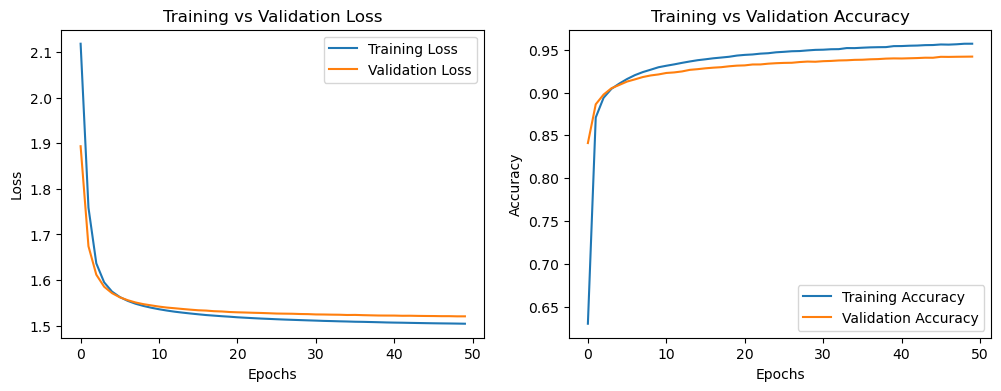

func:'train'  took: 11.6765 sec


  2%|▉                                           | 1/50 [00:00<00:10,  4.50it/s]

Epoch 1/50 - Loss: 2.111 - Acc: 0.671
              Val_loss: 1.882 - Val_acc: 0.855


 22%|█████████▍                                 | 11/50 [00:02<00:08,  4.62it/s]

Epoch 11/50 - Loss: 1.537 - Acc: 0.930
              Val_loss: 1.546 - Val_acc: 0.922


 42%|██████████████████                         | 21/50 [00:04<00:06,  4.26it/s]

Epoch 21/50 - Loss: 1.519 - Acc: 0.943
              Val_loss: 1.532 - Val_acc: 0.932


 62%|██████████████████████████▋                | 31/50 [00:07<00:04,  4.63it/s]

Epoch 31/50 - Loss: 1.512 - Acc: 0.950
              Val_loss: 1.527 - Val_acc: 0.937


 82%|███████████████████████████████████▎       | 41/50 [00:09<00:01,  4.75it/s]

Epoch 41/50 - Loss: 1.507 - Acc: 0.954
              Val_loss: 1.524 - Val_acc: 0.939


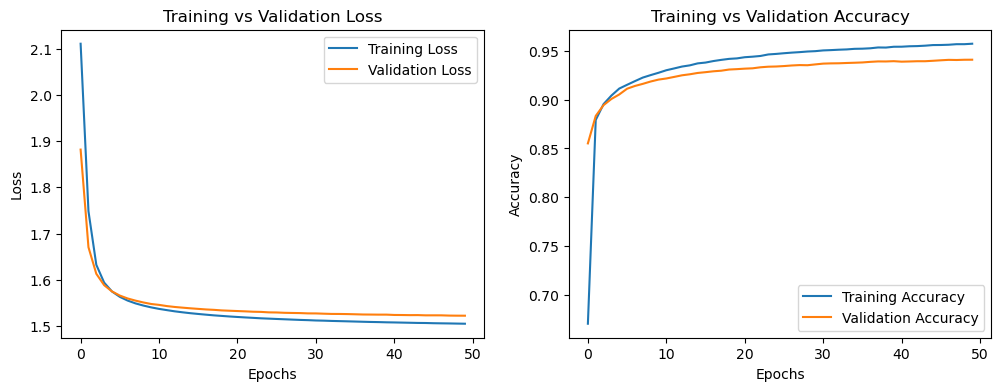

func:'train'  took: 11.1777 sec


  2%|▉                                           | 1/50 [00:00<00:10,  4.58it/s]

Epoch 1/50 - Loss: 2.109 - Acc: 0.640
              Val_loss: 1.883 - Val_acc: 0.857


 22%|█████████▍                                 | 11/50 [00:02<00:07,  4.97it/s]

Epoch 11/50 - Loss: 1.538 - Acc: 0.929
              Val_loss: 1.542 - Val_acc: 0.924


 44%|██████████████████▉                        | 22/50 [00:04<00:05,  5.00it/s]

Epoch 21/50 - Loss: 1.520 - Acc: 0.942
              Val_loss: 1.528 - Val_acc: 0.935


 62%|██████████████████████████▋                | 31/50 [00:06<00:03,  4.80it/s]

Epoch 31/50 - Loss: 1.512 - Acc: 0.950
              Val_loss: 1.524 - Val_acc: 0.939


 82%|███████████████████████████████████▎       | 41/50 [00:08<00:01,  4.65it/s]

Epoch 41/50 - Loss: 1.508 - Acc: 0.954
              Val_loss: 1.521 - Val_acc: 0.941


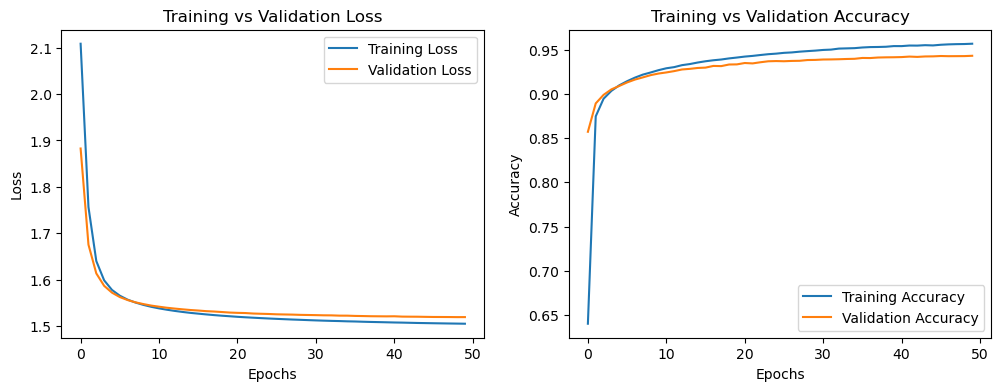

func:'train'  took: 10.5063 sec


In [11]:
kf = KFold(3, shuffle=True, random_state=49)

for idx, (train_index, val_index) in enumerate(kf.split(X_pca)):
    X_train_fold, X_val_fold = X_pca[train_index], X_pca[val_index]
    y_train_fold, y_val_fold = train_y[train_index], train_y[val_index]

    model5 = ANN(331, 50, 10)
    train_model5 = Trainer(model5, "Adam", 2e-3, 50, 128, input_transform=lambda x: x.reshape(-1, 331))
    model5_results = train_model5.train(X_train_fold, y_train_fold, X_val_fold, y_val_fold, l2=True)

The model in 2d is trained a bit faster than the previous ones, but only by 1-2 seconds on average. I guess on a large enough scale this would make a difference, but the time difference is not signficant in this assignment.

The accuracy is not much better really, it's more like the accuracy of the previous model that used L2 loss (2b)